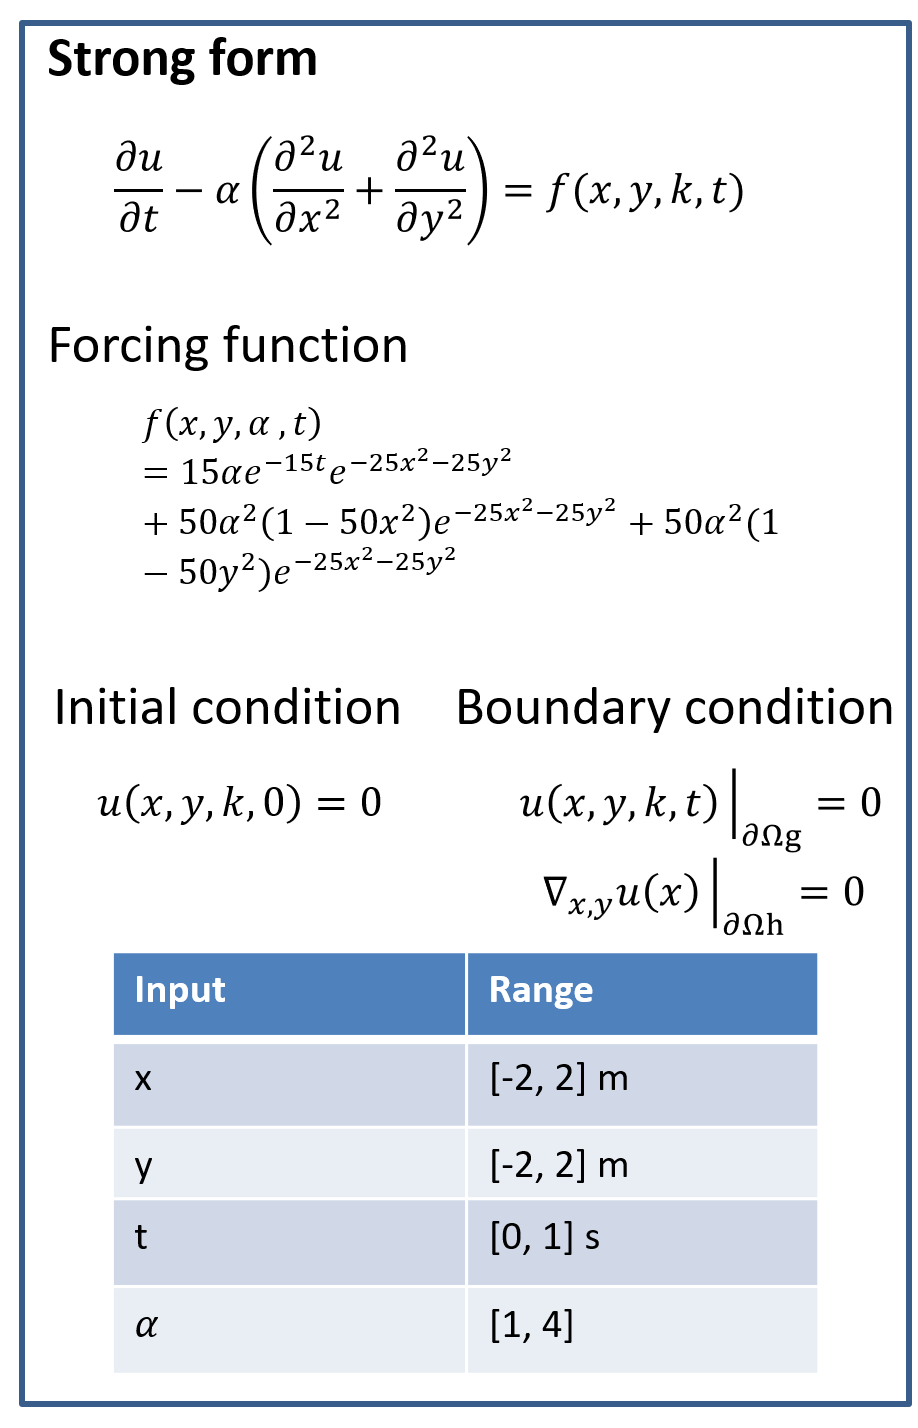

In [5]:
import numpy as onp
import jax
import jax.numpy as np
import time
import os,sys

currentdir = os.getcwd()
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)


from src.GPU_support import mem_report
from src.generate_mesh import *
from src.CFEM_shape_fun import *
from src.CFEM_utilities_STP_sparse import *


jax.config.update("jax_enable_x64", True)

onp.set_printoptions(threshold=sys.maxsize, linewidth=1000, suppress=True, precision=4)





start_time_org = time.time()


num_mode = 1
num_max_iter = 10

nelem_x = 100 # number of elements in the x direction
nelem_y = 100 # number of elements in the y direction
nelem_t = 300 # number of elements in the t direction
nelem_a = 400 # number of elements in the y direction

Lx = 4 # length of the domain
Ly = 4 # length of the domain
Lt = 1 # length of the domain
La = 3 # length of the domain
shift_x = Lx/2

s_patch_x = 2; s_patch_y = 2; s_patch_t = 2; s_patch_a = 2 # patch size
p_X = -1; p_Y = -1; p_T = -1; p_A = -1 # patch size
    
alpha_dil_x = 20; alpha_dil_y = 20; # dilation factor
alpha_dil_t = 20; alpha_dil_a = 20 # dilation factor

Gauss_Num_FEM = 2 # 6
Gauss_Num_CFEM = 8

p_dict={0:0, 1:2, 2:3, 3:4} 
mbasis = p_dict[2]  

# uniform body force
def fun_x1(x):
    b = 50 * np.exp(-25 * x**2) * (1 - 50 * x**2)
    return b
def fun_y1(y):
    b = np.exp(-25 * y**2)
    return b
def fun_t1(t):
    return (1 - np.exp(-15 * t))
def fun_a1(a):
    return a**2

def fun_x2(x):
    b = 50 * np.exp(-25 * x**2)
    return b
def fun_y2(y):
    b = np.exp(-25 * y**2) * (1 - 50 * y**2)
    return b
def fun_t2(t):
    return (1 - np.exp(-15 * t))
def fun_a2(a):
    return a**2

def fun_x3(x):
    b = 15 * np.exp(-25 * x**2)
    return b
def fun_y3(y):
    b = np.exp(-25 * y**2)
    return b
def fun_t3(t):
    return np.exp(-15 * t)
def fun_a3(a):
    return a

elem_type = 'D1LN2N' # 'D1LN2N'
nodes_per_elem = int(elem_type[4:-1]) #same for space and parameter for the same type of elements
dim = int(elem_type[1])
elem_dof = nodes_per_elem*dim    


fun_x_s = [fun_x1, fun_x2, fun_x3]  #
fun_y_s = [fun_y1, fun_y2, fun_y3]  #
fun_a_s = [fun_a1, fun_a2, fun_a3]  #
fun_t_s = [fun_t1, fun_t2, fun_t3]  #

nodes_per_elem = int(elem_type[4:-1]) #same for space and parameter for the same type of elements
dim = int(elem_type[1])
elem_dof = nodes_per_elem*dim    


fun_x_s_vvmap = [jax.jit(jax.vmap(jax.vmap(fun, in_axes = (0)), in_axes = (0))) for fun in fun_x_s]
fun_y_s_vvmap = [jax.jit(jax.vmap(jax.vmap(fun, in_axes = (0)), in_axes = (0))) for fun in fun_y_s]
fun_a_s_vvmap = [jax.jit(jax.vmap(jax.vmap(fun, in_axes = (0)), in_axes = (0))) for fun in fun_a_s]
fun_t_s_vvmap = [jax.jit(jax.vmap(jax.vmap(fun, in_axes = (0)), in_axes = (0))) for fun in fun_t_s]

force_fun_dict = {
    'x':fun_x_s_vvmap,
    'y':fun_y_s_vvmap,
    'a':fun_a_s_vvmap,
    't':fun_t_s_vvmap
}
## Mesh generation
non_uniform_mesh_bool = False
#XY_host: nodal coord; #Elem_nodes_host: element and its nodal id
x, Elem_nodes_x = uniform_mesh_new(Lx, nelem_x)
y, Elem_nodes_y = uniform_mesh_new(Ly, nelem_y)
t, Elem_nodes_t = uniform_mesh_new(Lt, nelem_t)
a, Elem_nodes_a = uniform_mesh_new(La, nelem_a)

x = x - shift_x
y = y - shift_x
a = a + 1.


## Displacement boundary condition
disp_BCx_idx = onp.array([0, -1], dtype = onp.int32)     # nodal index where the Dirichlet boundary condition is imposed
disp_BCx = onp.array([0., 0.], dtype=np.double) # Dirichlet boundary condition value

IC_idx = onp.array([0], dtype = onp.int32)     # nodal index where the Dirichlet boundary condition is imposed
IC = onp.array([0.], dtype=np.double) # Dirichlet boundary condition value


#####XTD
dof_global_x = nelem_x + 1; dof_global_y = nelem_y + 1
dof_global_t = nelem_t + 1; dof_global_a = nelem_a + 1

indices_x, indptr_x = get_adj_mat(Elem_nodes_x, nelem_x+1, s_patch_x)
indices_y, indptr_y = get_adj_mat(Elem_nodes_y, nelem_y+1, s_patch_y)
indices_t, indptr_t = get_adj_mat(Elem_nodes_t, nelem_t+1, s_patch_t)
indices_a, indptr_a = get_adj_mat(Elem_nodes_a, nelem_a+1, s_patch_a)
print(f"CFEM adj_s matrix took {time.time() - start_time_org:.4f} seconds")
# patch settings for X
d_c_x = Lx/nelem_x; d_c_y = Ly/nelem_y
d_c_t = Lt/nelem_t; d_c_a = La/nelem_a
a_dil_x = alpha_dil_x * d_c_x; a_dil_y = alpha_dil_y * d_c_y
a_dil_t = alpha_dil_t * d_c_t; a_dil_a = alpha_dil_a * d_c_a
start_time = time.time()
edex_max_x, ndex_max_x = get_dex_max(indices_x, indptr_x, s_patch_x, Elem_nodes_x)
edex_max_y, ndex_max_y = get_dex_max(indices_y, indptr_y, s_patch_y, Elem_nodes_y)
edex_max_t, ndex_max_t = get_dex_max(indices_t, indptr_t, s_patch_t, Elem_nodes_t)
edex_max_a, ndex_max_a = get_dex_max(indices_a, indptr_a, s_patch_a, Elem_nodes_a)

input_dict = {
    'coor':{'x':x, 'a': a, 't': t, 'y': y},
    'Elem_nodes':{'x':Elem_nodes_x, 'a': Elem_nodes_a, 't': Elem_nodes_t, 'y': Elem_nodes_y},
    'indices':{'x':indices_x, 'a': indices_a, 't': indices_t, 'y': indices_y},
    'indptr':{'x':indptr_x, 'a': indptr_a, 't': indptr_t, 'y': indptr_y},
    'edex_max':{'x':edex_max_x, 'a': edex_max_a, 't': edex_max_t, 'y': edex_max_y},
    'ndex_max':{'x':ndex_max_x, 'a': ndex_max_a, 't': ndex_max_t, 'y': ndex_max_y},
    's_patch':{'x':s_patch_x, 'a': s_patch_a, 't': s_patch_t, 'y': s_patch_y},
    'a_dil':{'x':a_dil_x, 'a': a_dil_a, 't': a_dil_t, 'y': a_dil_y},    
}

shape_fun_dict = get_CTD_shape_fun_dict(input_dict, mbasis, Gauss_Num_CFEM, elem_type)

N_til_x = shape_fun_dict['x']['N_til']; N_til_a = shape_fun_dict['a']['N_til']; N_til_t = shape_fun_dict['t']['N_til']; N_til_y = shape_fun_dict['y']['N_til']
Grad_N_til_x = shape_fun_dict['x']['Grad_N_til']; Grad_N_til_a = shape_fun_dict['a']['Grad_N_til']; Grad_N_til_t = shape_fun_dict['t']['Grad_N_til']; Grad_N_til_y = shape_fun_dict['y']['Grad_N_til']
JxW_x = shape_fun_dict['x']['JxW']; JxW_a = shape_fun_dict['a']['JxW']; JxW_t = shape_fun_dict['t']['JxW']; JxW_y = shape_fun_dict['y']['JxW']
Ele_patch_n_x = shape_fun_dict['x']['Elemental_patch_nodes_st']
Ele_patch_n_y = shape_fun_dict['y']['Elemental_patch_nodes_st']
Ele_patch_n_a = shape_fun_dict['a']['Elemental_patch_nodes_st']
Ele_patch_n_t = shape_fun_dict['t']['Elemental_patch_nodes_st']


(K_Bx_Bx, K_Nx_Nx) = get_matrix_x(x,Elem_nodes_x,N_til_x, Grad_N_til_x, 
                JxW_x, Ele_patch_n_x,
                Gauss_Num_CFEM, elem_type)

(K_By_By, K_Ny_Ny) = get_matrix_x(y,Elem_nodes_y,N_til_y, Grad_N_til_y, 
                JxW_y, Ele_patch_n_y,
                Gauss_Num_CFEM, elem_type)

(K_Nt_Bt, K_Nt_Nt) = get_matrix_t(t,Elem_nodes_t,N_til_t, Grad_N_til_t,
                JxW_t, Ele_patch_n_t,
                Gauss_Num_CFEM, elem_type)

(K_Na_a_Na, K_Na_Na) = get_matrix_k(a,Elem_nodes_a,N_til_a, Grad_N_til_a,
                JxW_a, Ele_patch_n_a,
                Gauss_Num_CFEM, elem_type)

K_Bx_Bx = bcoo_2_csr(K_Bx_Bx); K_Nx_Nx = bcoo_2_csr(K_Nx_Nx)
K_By_By = bcoo_2_csr(K_By_By); K_Ny_Ny = bcoo_2_csr(K_Ny_Ny)
K_Na_a_Na = bcoo_2_csr(K_Na_a_Na); K_Na_Na = bcoo_2_csr(K_Na_Na)
K_Nt_Bt = bcoo_2_csr(K_Nt_Bt); K_Nt_Nt = bcoo_2_csr(K_Nt_Nt)


ext_force_dict = get_ext_force_dict(input_dict, shape_fun_dict, force_fun_dict)

Qx_ext = onp.array(ext_force_dict['x'])
Qy_ext = onp.array(ext_force_dict['y'])
Qa_ext = onp.array(ext_force_dict['a'])
Qt_ext = onp.array(ext_force_dict['t'])



CFEM adj_s matrix took 0.0146 seconds
source_rank: 3


In [6]:
x = onp.array(x, dtype = onp.double)
y = onp.array(y, dtype = onp.double)
t = onp.array(t, dtype = onp.double)
a = onp.array(a, dtype = onp.double)


#Big loop: keep adding modes until convergence
modes = num_mode
U_x = onp.random.rand(modes, dof_global_x)
U_y = onp.random.rand(modes, dof_global_y)
U_t = onp.random.rand(modes, dof_global_t)
U_a = onp.random.rand(modes, dof_global_a)


variation0 = 1e10
for j in range(num_max_iter):
    U_x, U_y, U_t, U_a, variation, norm = \
        TD_solver_STP_2D_sylv(K_Bx_Bx, K_Nx_Nx, K_By_By, K_Ny_Ny, K_Na_Na, K_Na_a_Na,  
                  K_Nt_Nt, K_Nt_Bt, 
                  Qx_ext, Qy_ext, Qa_ext, Qt_ext,  
                  U_x, U_y, U_a, U_t, disp_BCx_idx, IC_idx)
    
    # if variation > variation0:
    #     break
    # else:
    #     variation0 = variation            
    norm_coef = (onp.linalg.norm(U_x) * onp.linalg.norm(U_y) * onp.linalg.norm(U_t) * onp.linalg.norm(U_a))**(1./4)
    U_x = norm_coef * U_x / onp.linalg.norm(U_x)
    U_y = norm_coef * U_y / onp.linalg.norm(U_y)
    U_t = norm_coef * U_t / onp.linalg.norm(U_t)
    U_a = norm_coef * U_a / onp.linalg.norm(U_a)

    print(f"Variation: {variation}, Norm: {norm}")
STP_sol = {}
STP_sol['U_x'] = U_x; STP_sol['U_y'] = U_y
STP_sol['U_t'] = U_t; STP_sol['U_a'] = U_a

print(f'{bcolors.HEADER}Finished, costs {time.time() - start_time} {bcolors.ENDC}')


Variation: 0.558938498091176, Norm: [ 0.3279 11.0365 12.2067]
Variation: 0.28640280997624207, Norm: [12.8174  7.316   7.3159]
Variation: 0.008141250438541019, Norm: [8.6893 8.546  8.546 ]
Variation: 0.00074851838889748, Norm: [8.605  8.5922 8.5922]
Variation: 7.075370481081311e-05, Norm: [8.5976 8.5964 8.5964]
Variation: 6.706209406783819e-06, Norm: [8.5969 8.5968 8.5968]
Variation: 6.3579516934497e-07, Norm: [8.5968 8.5968 8.5968]
Variation: 6.027926920324802e-08, Norm: [8.5968 8.5968 8.5968]
Variation: 5.715045966580446e-09, Norm: [8.5968 8.5968 8.5968]
Variation: 5.418407742376427e-10, Norm: [8.5968 8.5968 8.5968]
Finished, costs 2.7907466888427734 


## post-processing

In [7]:
@jax.jit
def CTD_STP_nodal_visual(U_x, U_y, U_t, U_k, id_k, id_t): #u(x) 
    '''
    generate 3d (x,y,z) data for visualization
    dim:(num_ele_x*num_quad, num_ele_y*num_quad, num_ele_z*num_quad)
    
    '''
    num_mode = U_x.shape[0]
        
    #shape_vals: (quad_num, nodes_per_elem)->         (num_mode, quad_num, nelem, nodes_per_elem) 
    ###############################################################################To be modified
    #  N_til_x:  (nelem, quad_num, edex_max_x)  --> ((num_mode), nelem, quad_num, edex_max_x) 
    #  um_nodal: (num_mode, nelem, edex_max_x)  -->  (num_mode,  nelem, (quad_num), edex_max_x)
    
    t_interpolated = U_t[:, id_t] #dim (num_mode)
    k_interpolated = U_k[:, id_k] #dim (num_mode)
    #u_x(num_mode, nelem_x, num_quad_x) * (num_mode) sum along axis 0 
    U = np.sum(U_x[:, :, None] * U_y[:, None, :] * t_interpolated[:, None, None] * \
               k_interpolated[:, None, None], axis = 0) #dim(num_points_x)
    return U  #dim(num_points_x, num_points_y, num_points_z)

In [ ]:
# %%timeit

# U0 = CTD_STP_nodal_visual(U_x, U_y, U_t, U_a, 0, 0)

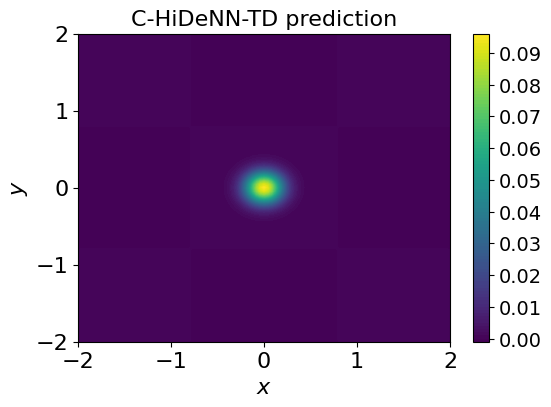

In [8]:
id_a = 0
id_t = 2
import matplotlib.pyplot as plt
# Create meshgrid for plotting
X, Y = np.meshgrid(x.reshape(-1), y.reshape(-1))

num_levels = 100
# Create a figure with two subplots
fig, axes = plt.subplots(figsize=(6, 4))

    # Perform TAPSO update
U0 = CTD_STP_nodal_visual(U_x, U_y, U_t, U_a, id_a, id_t)


contour1 = axes.contourf(X, Y, U0.T, levels=num_levels,cmap='viridis')
axes.set_title('C-HiDeNN-TD prediction', fontsize=16)
axes.set_xlabel('$x$', fontsize=16)
axes.set_ylabel('$y$', fontsize=16)
axes.tick_params(axis='both', labelsize=16)
cbar1 = fig.colorbar(contour1, ax=axes)
cbar1.ax.tick_params(labelsize=14)


## analyical solution

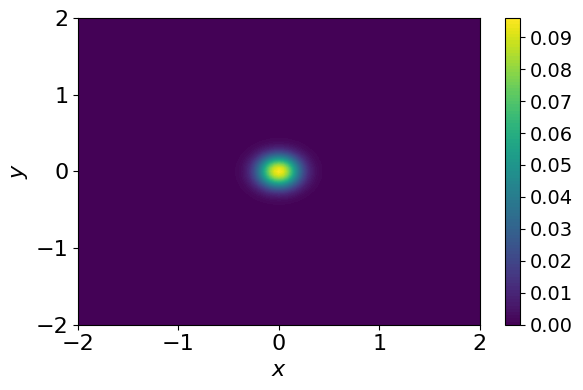

In [9]:
def u_ex(x, y, t, a):
    return np.exp(-25 * (x)**2) * np.exp(-25 * (y)**2) * (1 - np.exp(-15 * t)) * a


U_ex = u_ex(X,Y,t.reshape(-1)[id_t], a.reshape(-1)[id_a])

fig2, axes2 = plt.subplots(figsize=(6, 4))
contour2 = axes2.contourf(X, Y, U_ex.T, levels=num_levels,cmap='viridis')
axes2.set_xlabel('$x$', fontsize=16)
axes2.set_ylabel('$y$', fontsize=16)
axes2.tick_params(axis='both', labelsize=16)
cbar2 = fig2.colorbar(contour2, ax=axes2)
cbar2.ax.tick_params(labelsize=14)
plt.tight_layout()
plt.show()